[]
No ani data for skani_mash.pdf
[]
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Kuttervirus/ani_metrics_Kuttervirus.csv']
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Kuttervirus/mash_metrics_Kuttervirus.csv']
[]
No ani data for fastani_mash.pdf
[]
[]
No ani data for fastani_sourmash.pdf
[]
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Tequintavirus/ani_metrics_Tequintavirus.csv']
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Tequintavirus/mash_metrics_Tequintavirus.csv']
[]
No ani data for skani_sourmash.pdf
[]
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Cheoctovirus/ani_metrics_Cheoctovirus.csv']
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Cheoctovirus/mash_metrics_Cheoctovirus.csv']
['/hpcfs/home/ciencias_biologicas/na.portilla10/phallet/Metrics_Results/Skunavirus/ani_metrics_Skunavirus.csv']
['/hpcfs/home/ciencias_biolog

/tmp/ipykernel_356568/2773356310.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


        GenomeA   GenomeB  ani_distance kmer_ani algorithm
0      FQ312032  FQ312032      100.0000        9   fastani
1      FQ312032  JX128257       97.9076        9   fastani
2      FQ312032  KJ174317       96.8405        9   fastani
3      FQ312032  KF669654       95.4688        9   fastani
4      FQ312032  KF669653       94.5959        9   fastani
...         ...       ...           ...      ...       ...
87690  OL800604  MT074466       89.0615        9   fastani
87691  OL800604  MK972707       88.9872        9   fastani
87692  OL800604  LR027389       88.9565        9   fastani
87693  OL800604  MT074449       88.8014        9   fastani
87694  OL800604  HE956708       83.1808        9   fastani

[17727 rows x 5 columns]
         GenomeA   GenomeB  mash_distance  kmer_mash algorithm
4107    FQ312032  FQ312032       0.000000         17      mash
4108    HQ259103  FQ312032       0.089319         17      mash
4109    JN126049  FQ312032       0.080781         17      mash
4110    JN5932

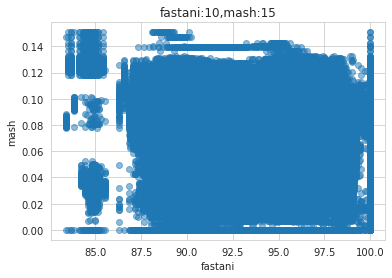

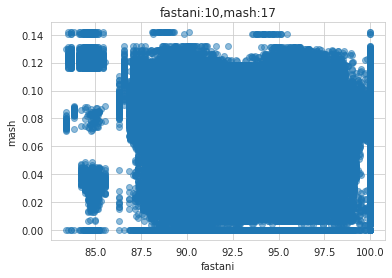

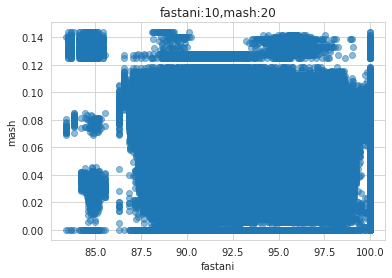

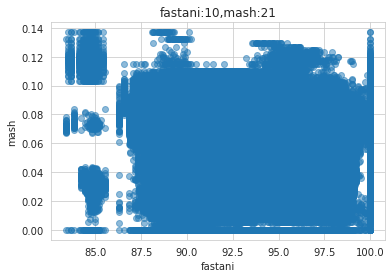

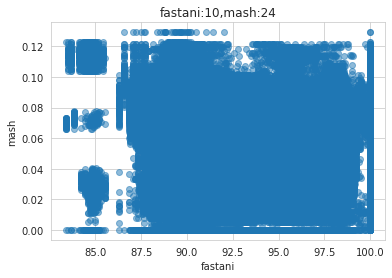

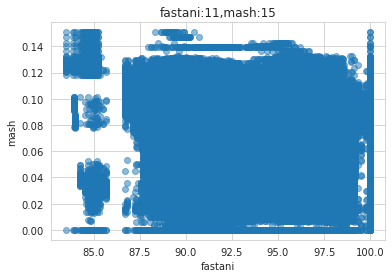

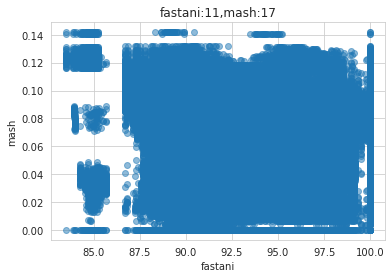

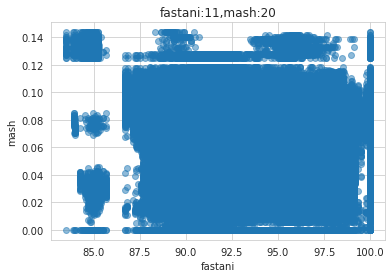

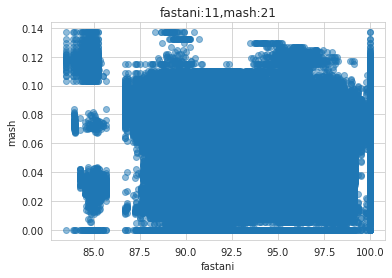

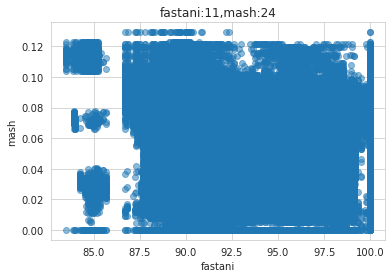

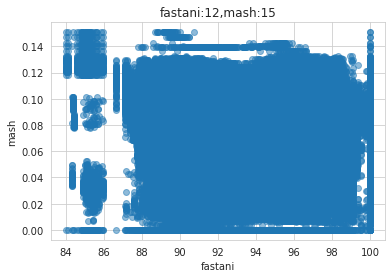

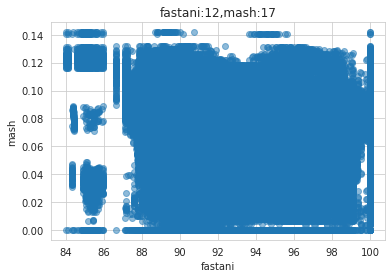

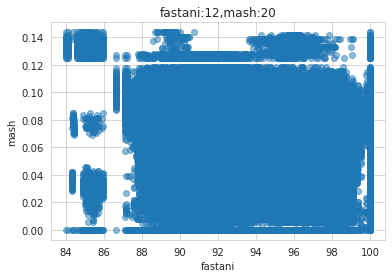

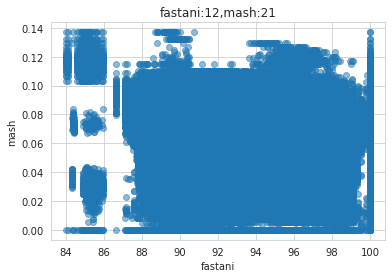

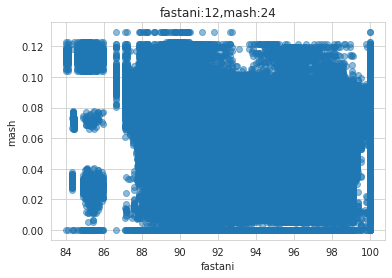

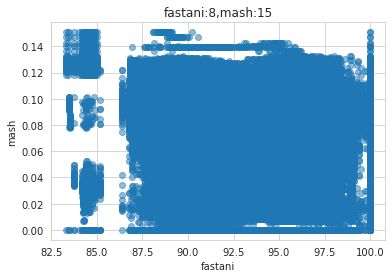

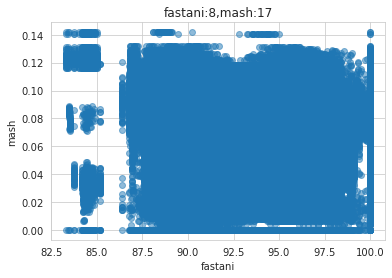

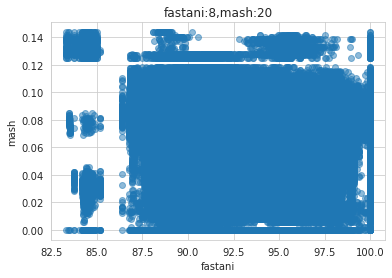

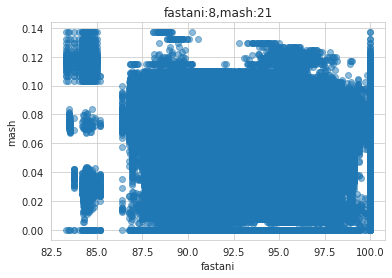

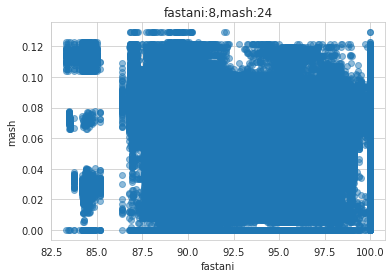

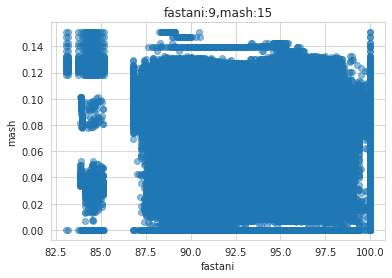

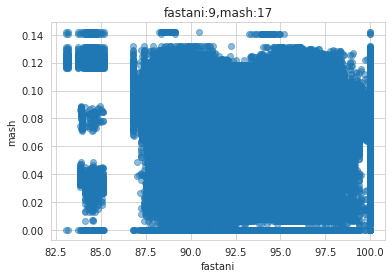

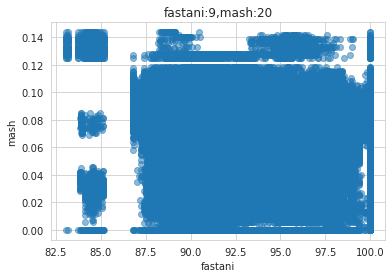

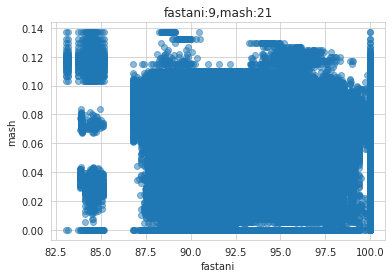

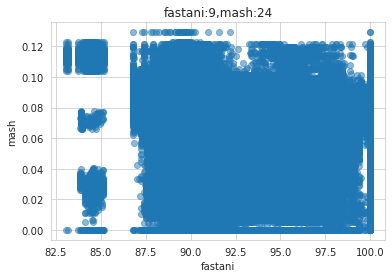

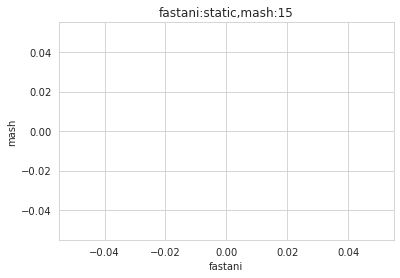

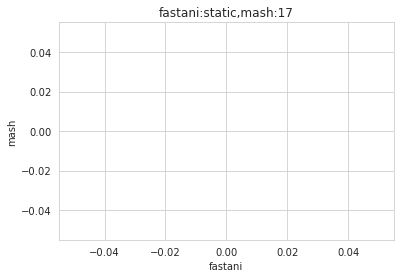

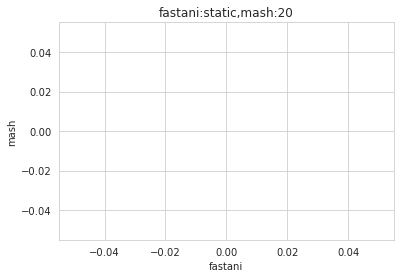

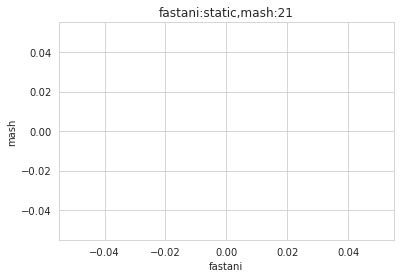

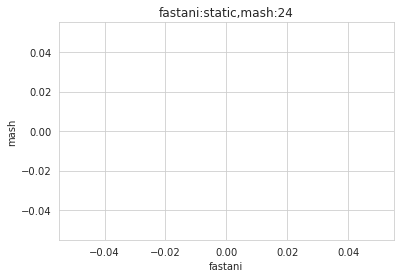

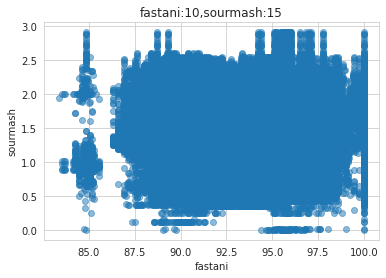

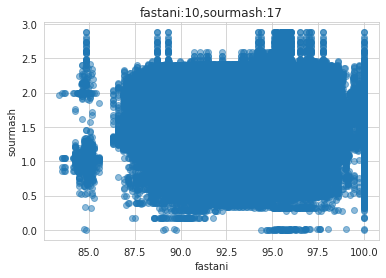

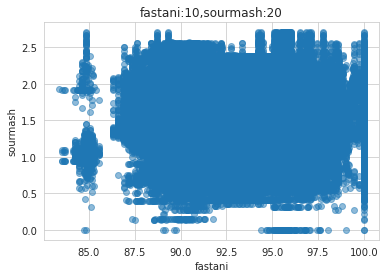

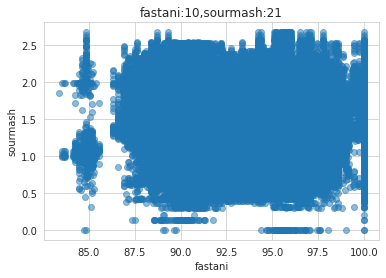

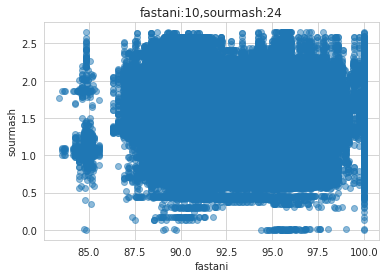

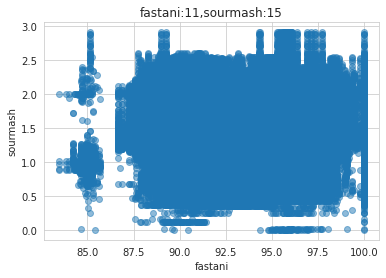

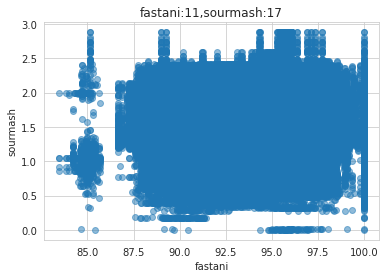

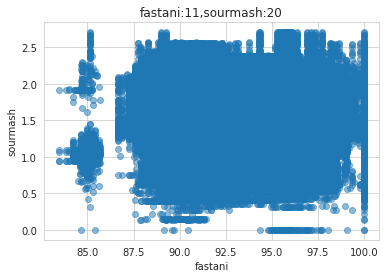

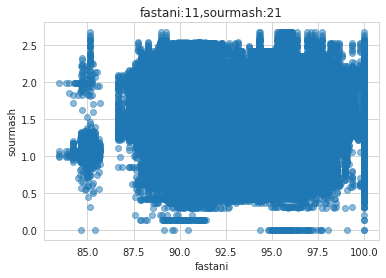

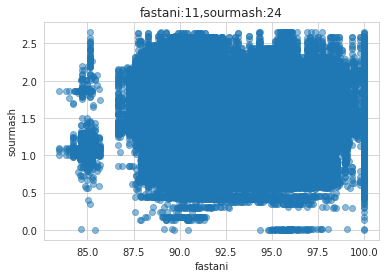

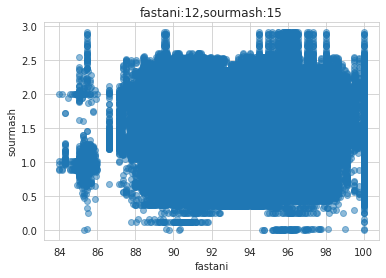

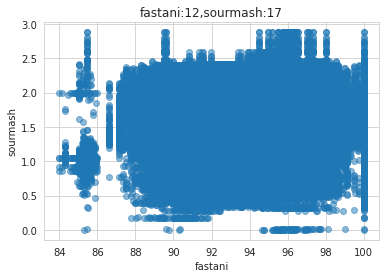

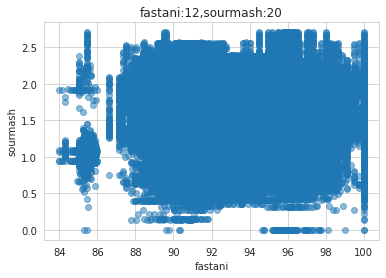

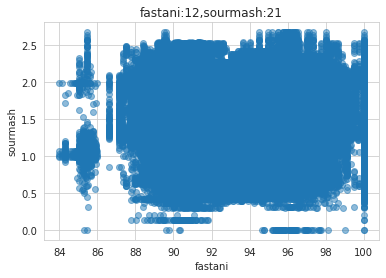

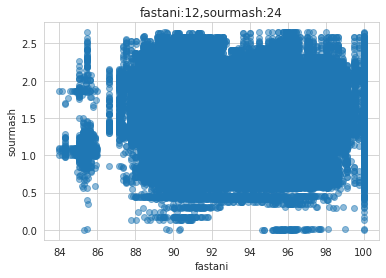

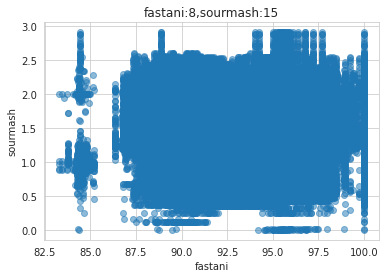

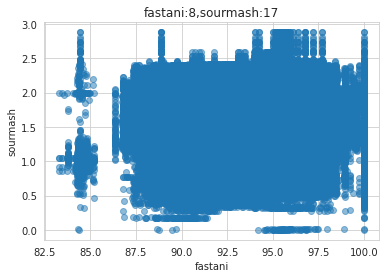

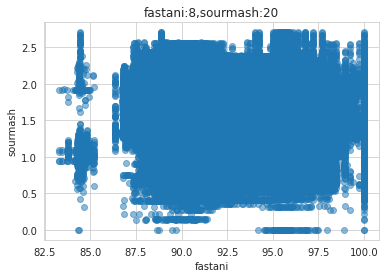

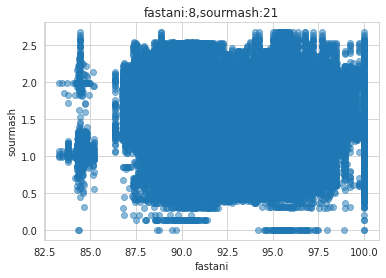

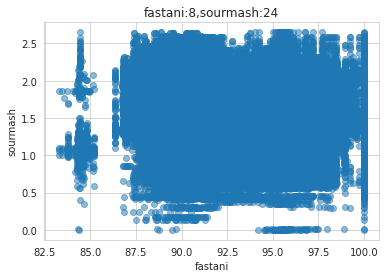

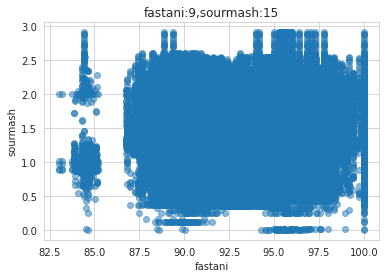

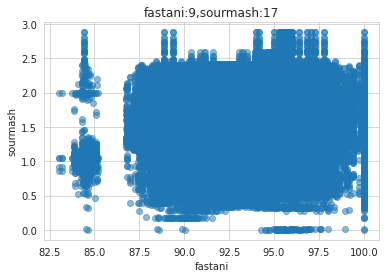

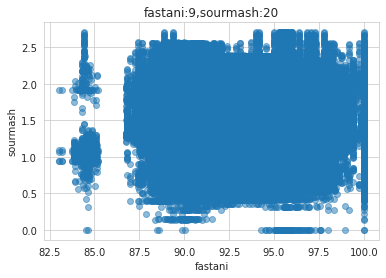

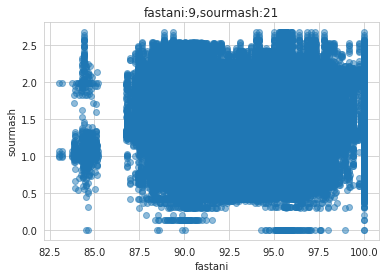

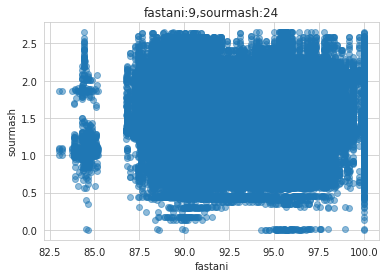

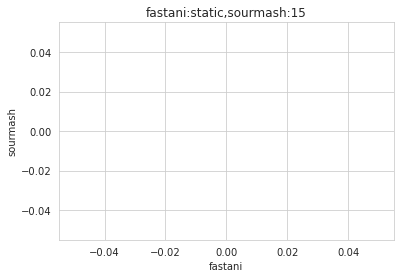

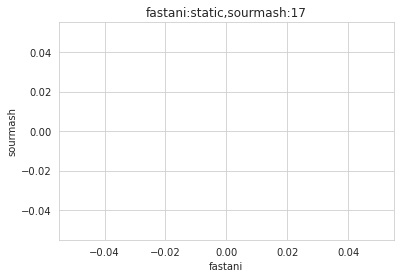

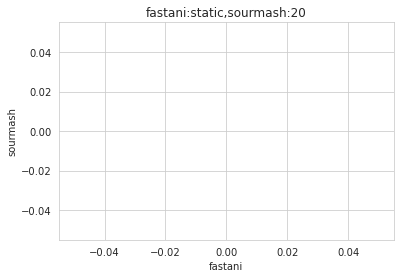

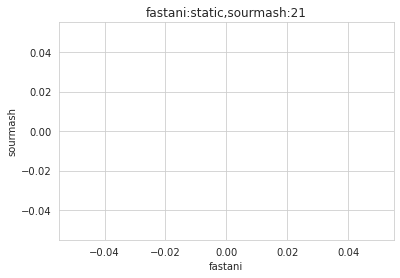

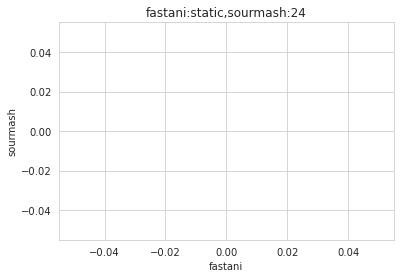

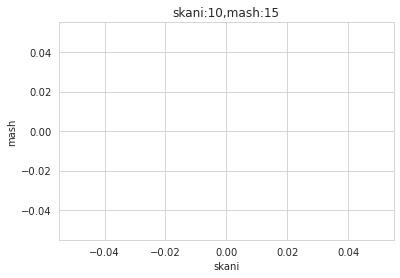

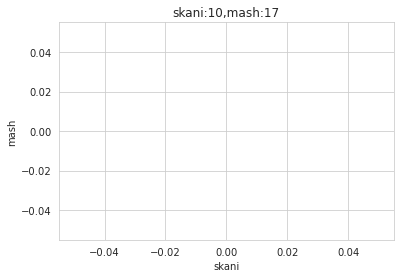

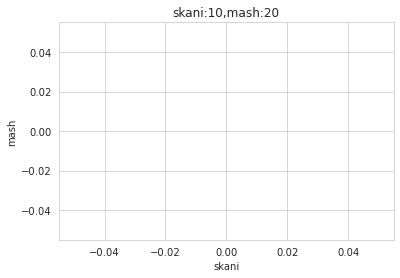

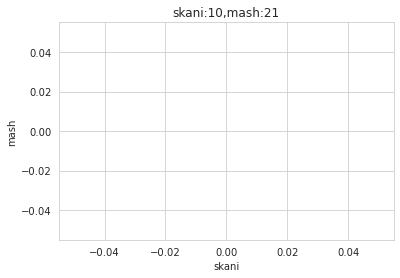

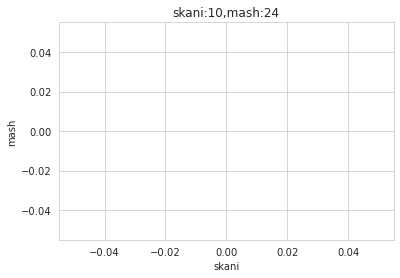

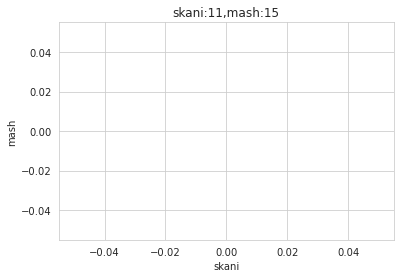

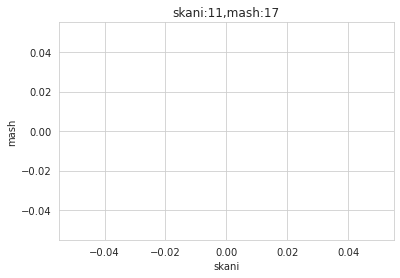

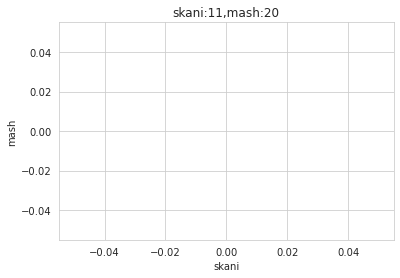

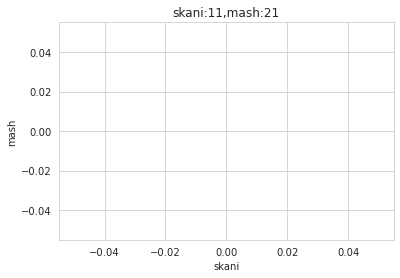

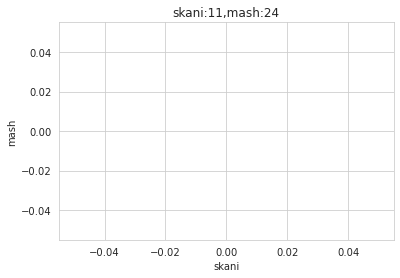

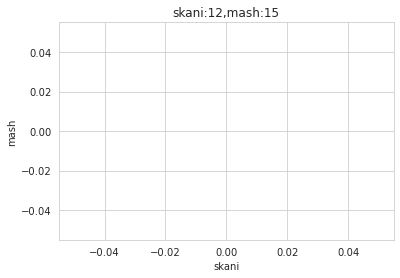

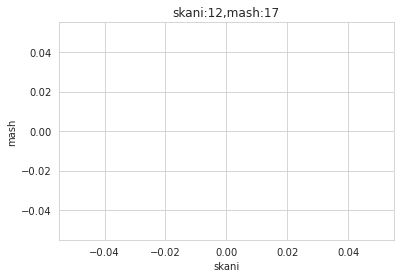

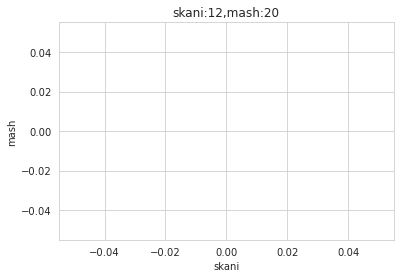

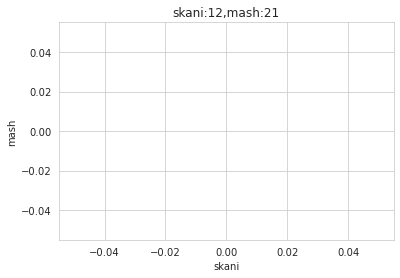

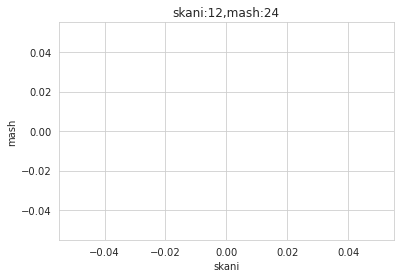

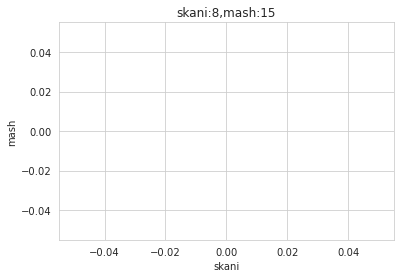

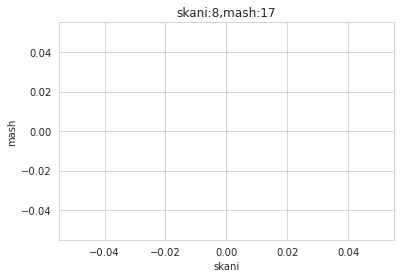

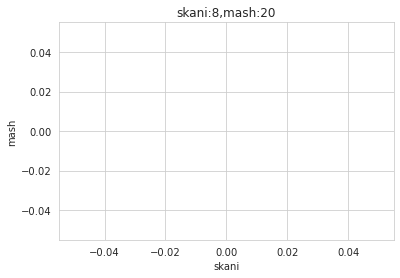

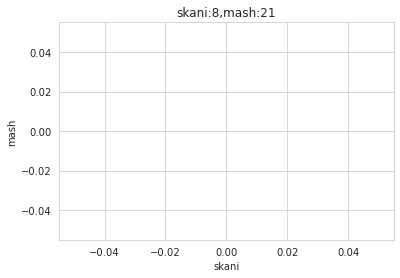

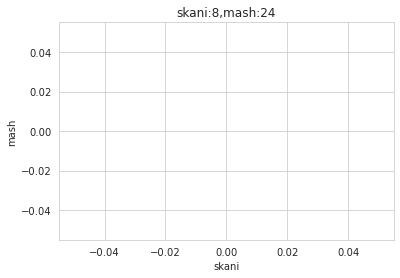

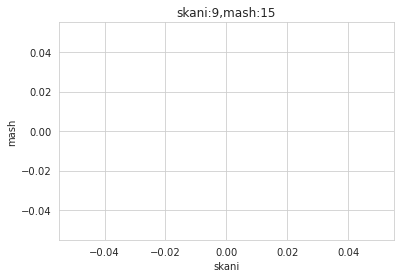

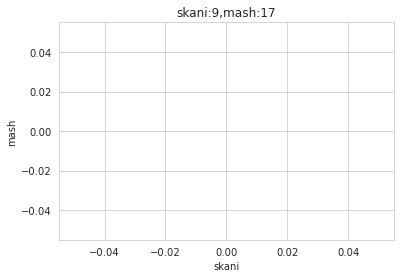

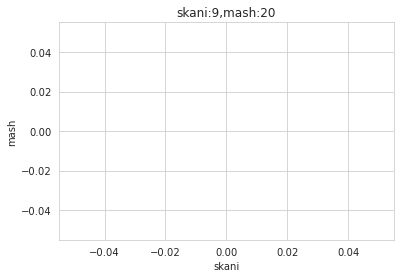

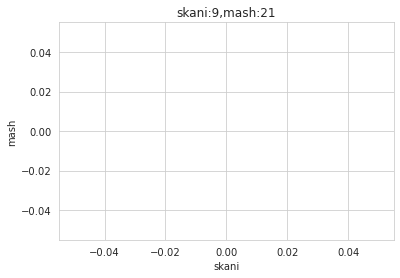

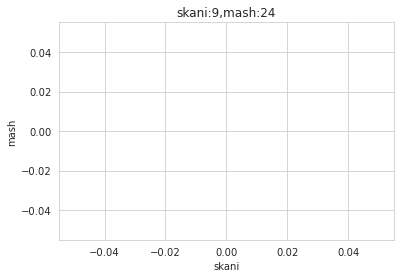

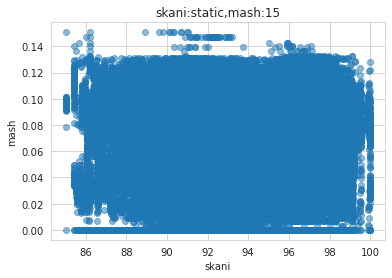

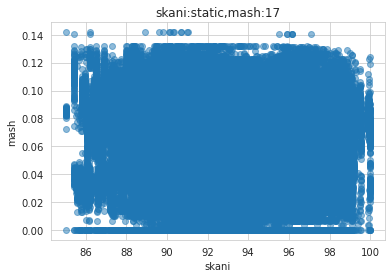

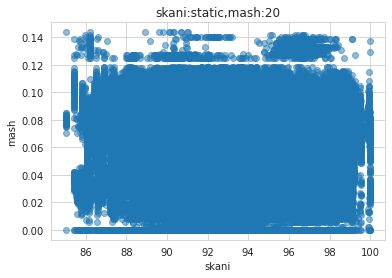

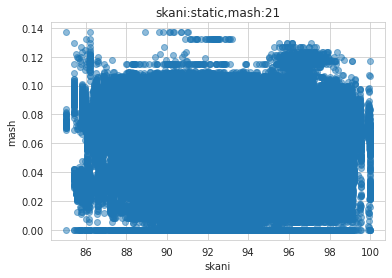

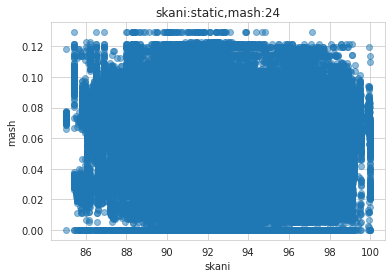

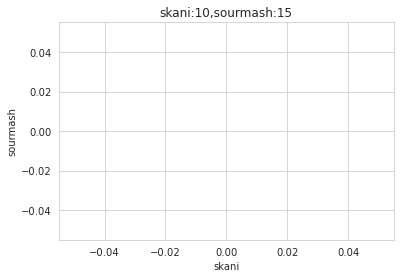

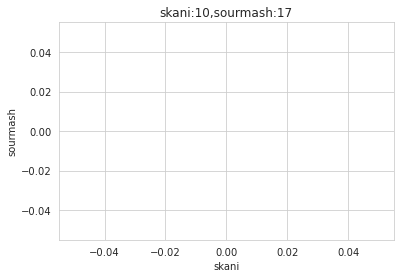

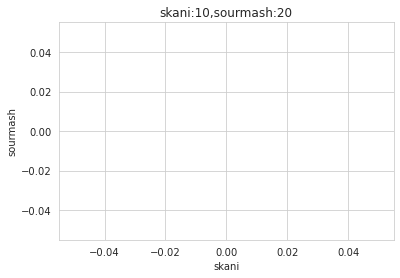

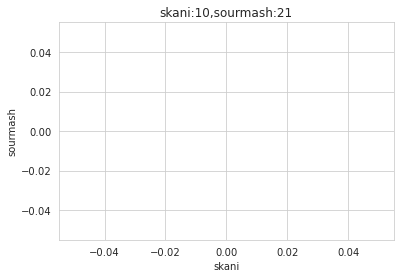

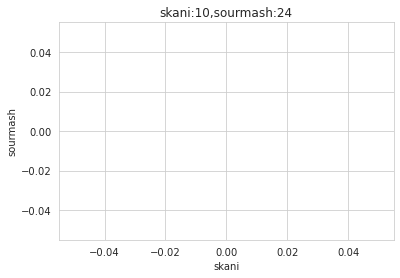

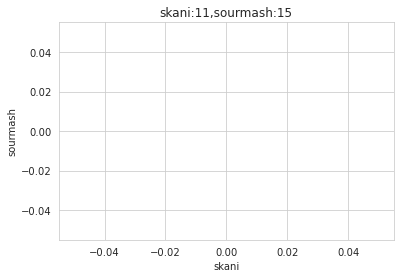

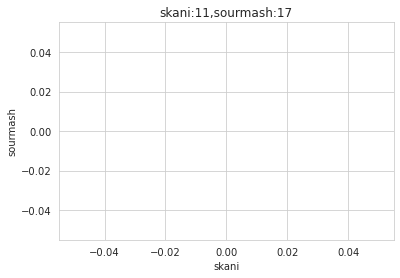

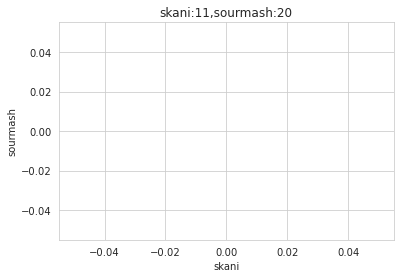

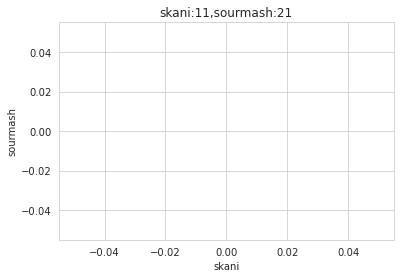

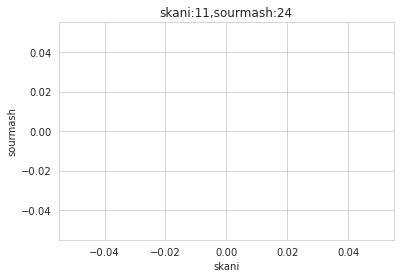

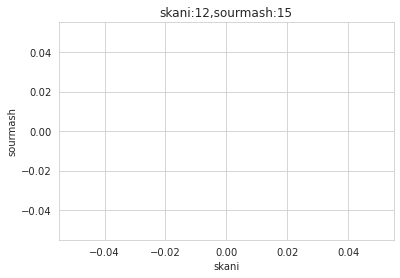

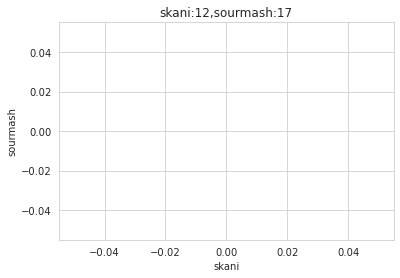

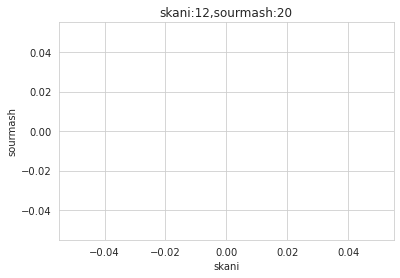

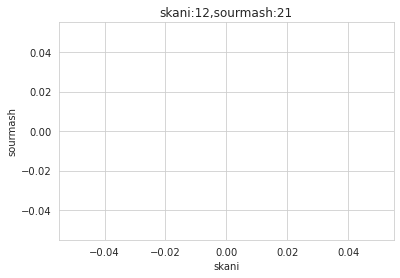

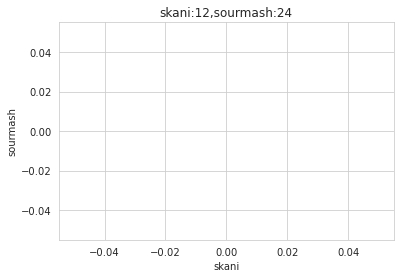

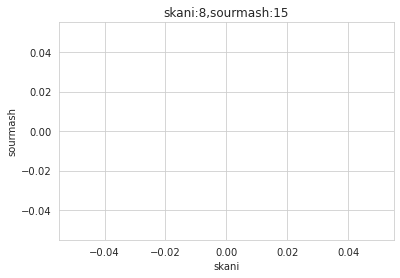

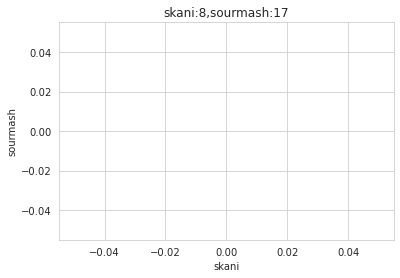

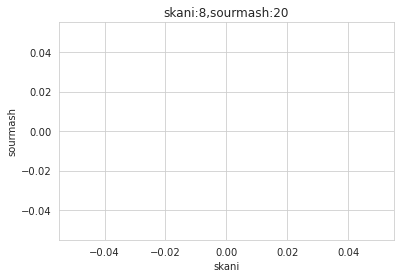

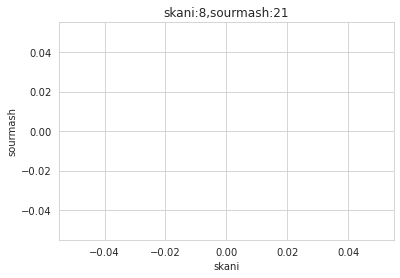

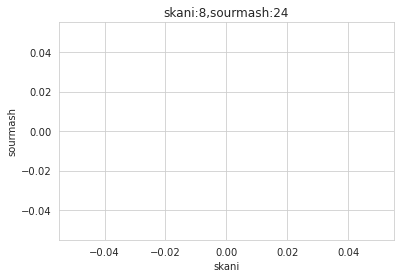

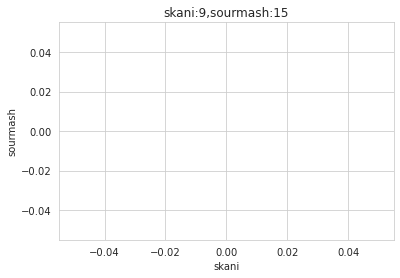

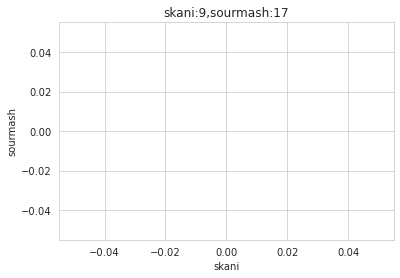

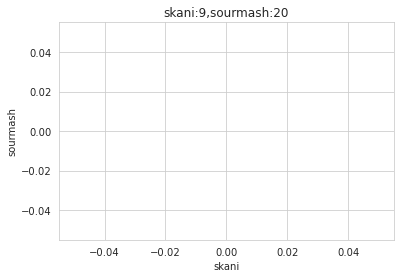

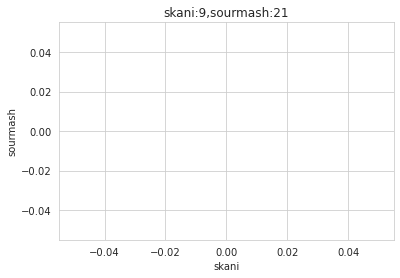

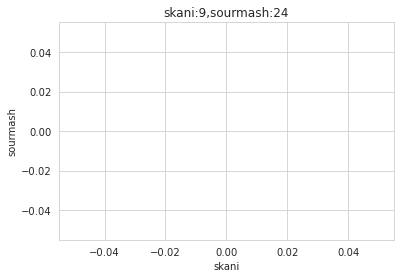

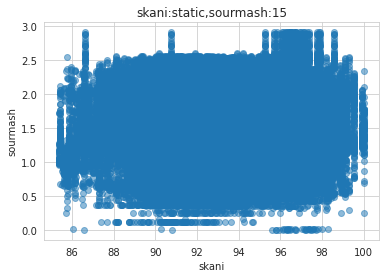

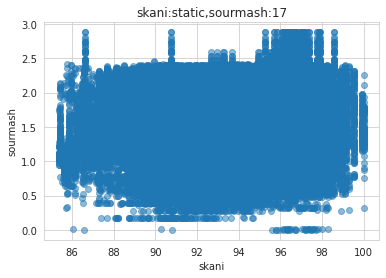

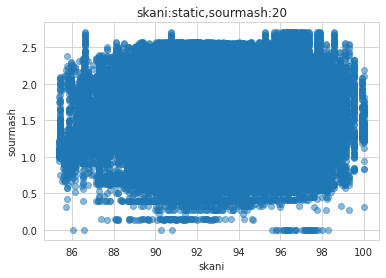

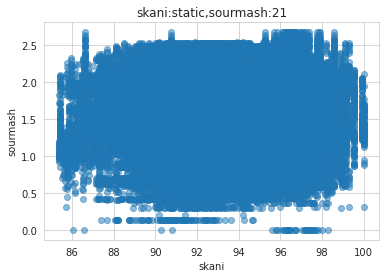

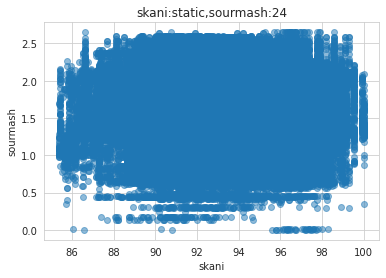

In [15]:
import os
import re
import glob
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Set working directory
workdir = os.path.expanduser("~/phallet/Metrics_Results")
subdirectories=[d for d in os.listdir(workdir)]

# Read command-line arguments
args = sys.argv[1:]
mx = "ani"
kmersx = [12, 11, 10, 9, 8]
my = "mash"
kmersy = [15, 17, 20, 21, 24]

# Remove any arguments that are not valid integers
args = [arg for arg in args if re.match(r'^\d+$', arg)]

# Cases for metrics selected on Y
if my == "mash":
    tool_my = ["mash", "sourmash"]
elif my == "ani":
    tool_my = ["fastani", "skani"]
elif my == "aai":
    tool_my = ["comparem"]
elif my == "viridic":
    tool_my = ["viridic"]
elif my == "vcontact2":
    tool_my = ["vcontact2"]
    
if mx == "mash":
    tool_mx = ["mash", "sourmash"]
elif mx == "ani":
    tool_mx = ["fastani", "skani"]
elif mx == "aai":
    tool_mx = ["comparem"]
elif mx == "viridic":
    tool_mx = ["viridic"]
elif mx == "vcontact2":
    tool_mx = ["vcontact2"]

metrics = [mx, my]

ani_data=pd.DataFrame()
mash_data=pd.DataFrame()
viridic_data=pd.DataFrame()

for m in metrics:
    if m==mx:
        kmers=kmersx
        tool_mx=tool_mx
    if m==my:
        kmers=kmersy
        tool_my=tool_my

# Retrieve information for each metric

for genus in subdirectories:
    os.chdir(workdir)
    genus_name = os.path.basename(genus)
    genus_dir= os.path.join(workdir,genus_name)
    summaries = glob.glob(os.path.join(genus_dir,"*metrics*.csv"))

    if mx in metrics:
        mx_files=[s for s in summaries if f"{mx}_metrics_" in s]
        print(mx_files)
        if len(mx_files)>0:
            mx_data = pd.read_csv(mx_files[0])
            kmer_values_mx = sorted(pd.unique(mx_data[f"kmer_{mx}"]))
        else:
            print(f"No {mx} data for {genus_name}")
    if my in metrics:
        my_files=[s for s in summaries if f"{my}_metrics_" in s]
        print(my_files)
        if len(my_files)>0:
              my_data = pd.read_csv(my_files[0])
              kmer_values_my = sorted(pd.unique(my_data[f"kmer_{my}"]))
   
# Assuming merged_df is your DataFrame
for algorithm_mx in tool_mx:
    for algorithm_my in tool_my:
        # Subset the data for the current combination
        df_subset_mx = mx_data[mx_data["algorithm"]==algorithm_mx]
        df_subset_my = my_data[my_data["algorithm"]==algorithm_my]

        # Create a scatterplot for each kmer combination
        for mx_kmer in kmer_values_mx:
            for my_kmer in kmer_values_my:

                # Subset the data for the current kmer_mx and kmer_my
                df_subset_mx_kmer = df_subset_mx[df_subset_mx[f"kmer_{mx}"] == mx_kmer]
                print(df_subset_mx_kmer)
                df_subset_my_kmer = df_subset_my[df_subset_my[f"kmer_{my}"] == my_kmer]
                print(df_subset_my_kmer)
                merged_df = pd.merge(df_subset_my_kmer, df_subset_mx_kmer, left_on="GenomeA", right_on="GenomeB")

                # Create a scatterplot for the current kmer_mx and kmer_my
                fig, ax = plt.subplots()
                ax.set_xlabel(algorithm_mx)
                ax.set_ylabel(algorithm_my)
                ax.set_title(f"{algorithm_mx}:{mx_kmer},{algorithm_my}:{my_kmer}")
                ax.scatter(merged_df[f"{mx}_distance"],merged_df[f"{my}_distance"],alpha=0.5)
                # Save the current figure to a PDF file
    
                pdf_filename = f"{algorithm_mx}_{algorithm_my}.pdf"
                with PdfPages(pdf_filename) as pdf:
                    pdf.savefig(fig)

# Show a message when the PDF files have been created
print("PDF files created successfully.")
   